In [22]:
import os 
import mne
import numpy as np
import torch
import torch.nn as nn
import torchvision
from functools import partial
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
def scale_clamp(X: np.ndarray, clamp_lim: float = 5.0, clamp: bool = True) -> np.ndarray:
  X = X.reshape(X.shape[0], -1)
  X = RobustScaler().fit_transform(X)
  if clamp:
      X = X.clip(min=-clamp_lim, max=clamp_lim)
  return X.squeeze()


class meg_dataset(torch.utils.data.Dataset):
  def __init__(self, root, s: str):
    self.root = root
    nights = ['night1', 'night2', 'night3', 'night4']

    self.all_meg_data = []
    self.all_epochs = []
    for night in nights:
      data_path_folder = os.path.join(self.root, rf'{s}\{night}')

      import re

      files = [f for f in os.listdir(data_path_folder) if re.match(r'^\d', f)]
      files.sort()
      wm = files[-1]

      self.data_path = os.path.join(self.root, rf'{s}\{night}\{wm}')

      raw = mne.io.read_raw_ctf(self.data_path, preload=True)
      raw.pick_types(meg=True, stim=True, eeg=True, ref_meg=True)
      events = mne.find_events(raw, stim_channel='UDIO001', initial_event=True, min_duration=1/raw.info['sfreq'])
      event_ids = {"maint_FACE": 43, "maint_HOUSE": 53}

      events[:,2] = events[:,2] - 255
      sel = np.where(events[:, 2] <= 255)[0]
      events = events[sel, :]
      picks = mne.pick_types(raw.info, meg='mag', eeg=True, stim=False,
                              exclude='bads')
      self.epochs = mne.Epochs(raw, events, event_ids,  picks=picks,tmin=-.2, tmax=4,\
                          baseline=None, preload=True)
      self.epochs.resample(120)   ### filtert es schonb?
      self.epochs.apply_function(partial(scale_clamp, clamp_lim=5.0), n_jobs=8)
      self.meg_data = torch.from_numpy(self.epochs.get_data(picks='meg')).to(torch.float32)
      self.all_meg_data.append(self.meg_data)
      self.all_epochs.append(self.epochs)

    self.all_meg_data = torch.cat(self.all_meg_data, dim=0)
    for ep in self.all_epochs:
      ep.info['dev_head_t'] = self.all_epochs[0].info['dev_head_t']
    self.all_epochs = mne.concatenate_epochs(self.all_epochs)
    
  def __len__(self):
    return len(self.all_meg_data)
  
  def __getitem__(self, idx):
    return self.all_meg_data[idx, :, :], self.all_epochs.events[idx, 2], self.all_epochs[idx]

In [25]:

class CustomBatchNorm1d(nn.BatchNorm1d):
    def forward(self, input):
        if input.size(0) == 1:
            return input
        return super().forward(input)

class NaiveModel(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()

        self.backbone = backbone

        out_features = list(self.backbone.modules())[-1].out_features
        
        self.cls_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(out_features, 512),
            CustomBatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            CustomBatchNorm1d(128),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            CustomBatchNorm1d(64),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        x = self.backbone(x)
        
        output = self.cls_head(x)
        return output

In [26]:
dataset = meg_dataset(root = r'\\memo-15\DataE\MEGA\raw', s = 'S02')

train_idcs = np.arange(0, len(dataset))
np.random.seed(42)
np.random.shuffle(train_idcs)
train_idcs = train_idcs[:int(len(train_idcs)*0.8)]
test_idcs = np.setdiff1d(np.arange(0, len(dataset)), train_idcs)
train_idcs = torch.from_numpy(train_idcs).to(device)
test_idcs = torch.from_numpy(test_idcs).to(device)
train_dataset = torch.utils.data.Subset(dataset, train_idcs)
test_dataset = torch.utils.data.Subset(dataset, test_idcs)


clear_output()
print(len(dataset))

ds directory : \\memo-15\DataE\MEGA\raw\S02\night1\02_Sleep_20170602_10.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -2.87   79.10    0.00 mm <->   -2.87   79.10   -0.00 mm (orig :  -50.42   52.82 -311.88 mm) diff =    0.000 mm
       2.87  -79.10    0.00 mm <->    2.87  -79.10   -0.00 mm (orig :   68.69  -51.36 -307.29 mm) diff =    0.000 mm
     102.21    0.00    0.00 mm <->  102.21    0.00   -0.00 mm (orig :   71.76   68.63 -265.85 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    10 EEG electrode locations assigned to channel info.
    10 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for \\memo-15\DataE\MEGA\raw\S02\night1\02_Sleep_20170602_10.ds\02_Sleep_20170602_10.meg4: 
    System clock channel is available, checking which samples ar

KeyboardInterrupt: 

1600 1280 320
torch.Size([296, 504]) 53


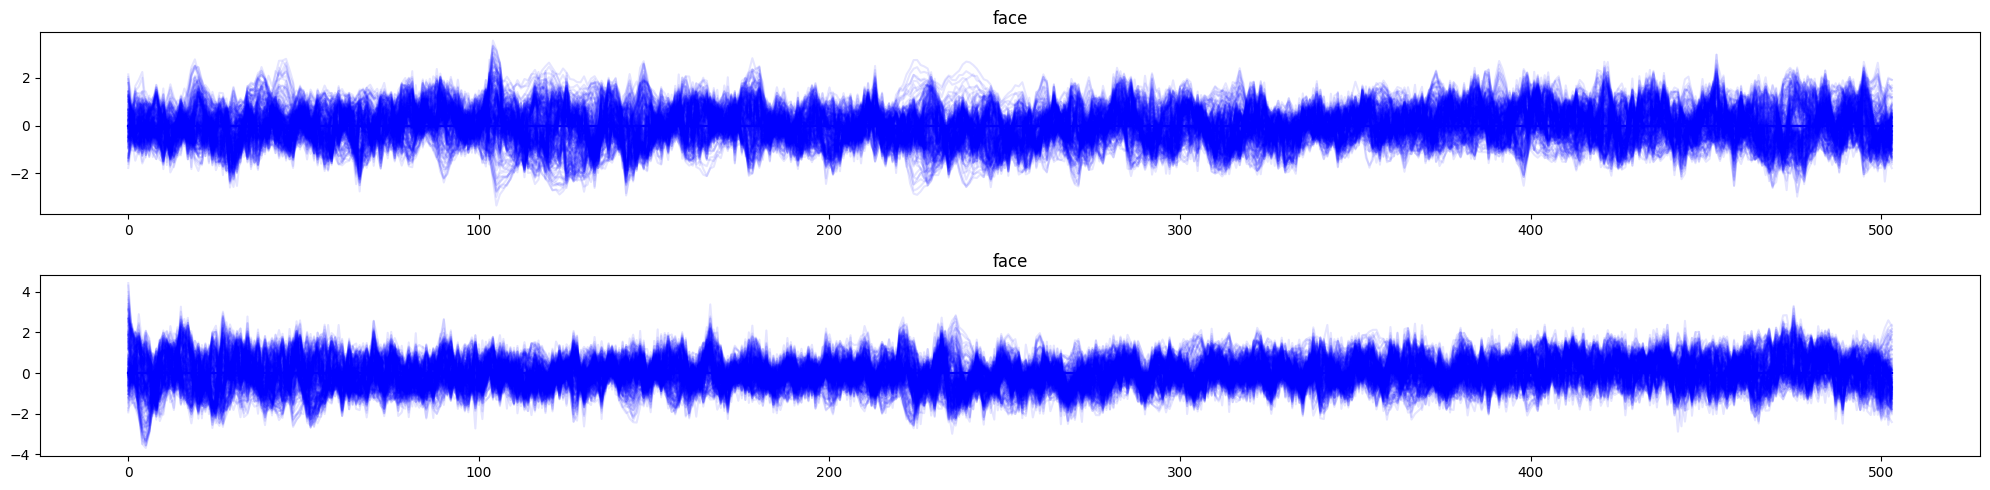

In [19]:
print(len(dataset), len(train_dataset), len(test_dataset))
fig, ax = plt.subplots(2, 1, figsize=(20, 5))
for idx, ax in enumerate(ax.flatten()):
    np.random.seed(idx)
    rnd_int = np.random.randint(0, len(dataset))
    meg, label, x = dataset[np.random.randint(0, len(dataset))]
    for i in range(meg.shape[0]):
        ax.plot(meg[i, :].numpy(), color='blue', alpha=0.1)
    ax.set_title(f'{'house' if label == 43 else 'face'}')
print(meg.shape, label)
plt.tight_layout()
plt.show()



In [ ]:
# Extract data and labels from the dataset
all_data = dataset.all_meg_data.numpy()  # Shape: (samples, channels, time)
all_labels = dataset.all_epochs.events[:, 2]  # Labels

# Flatten the time dimension for each channel
flattened_data = all_data.mean(axis=2)  # Shape: (samples, channels)

# Calculate correlation for each channel
correlations = []
for channel_idx in range(flattened_data.shape[1]):
  channel_data = flattened_data[:, channel_idx]
  correlation = np.corrcoef(channel_data, all_labels)[0, 1]
  correlations.append(correlation)

# Display the correlations
for idx, corr in enumerate(correlations):
  if corr > 0.5:
    print(f"Channel {idx}: Correlation with label = {corr:.4f}")

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
model = BrainEncoder([2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
test_loss, test_acc = [], []
train_loss, train_acc = [], []
for epoch in range(30):
    model.train()
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch', leave=False)
    lossinho = 0
    correct = 0
    total = 0
    for idx, (data, target) in enumerate(progress_bar):
        target = [0 if i == 43 else 1 for i in target]
        #data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        data = data[:, :271, :]
        data, target = data.to(device), torch.tensor(target).to(device)
        output = model(data, subject_idxs=np.zeros_like(target))
        loss = loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lossinho += loss.item()
        progress_bar.set_postfix(loss=lossinho/(idx+1))

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1} Loss: {lossinho/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')
    train_loss.append(lossinho/len(train_loader))
    train_acc.append(accuracy)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        lossinho = 0
        for data, target in test_loader:
            target = [0 if i == 43 else 1 for i in target]
            #data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
            data = data[:, :271, :]
            data, target = data.to(device), torch.tensor(target).to(device)
            output = model(data, subject_idxs=np.zeros_like(target))
            loss = loss_fn(output, target)
            lossinho += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        print(f'Accuracy: {accuracy:.2f}%, Loss: {lossinho/len(test_loader):.4f}')
    test_loss.append(lossinho/len(test_loader))
    test_acc.append(accuracy)

Epoch 1 Loss: 0.6937, Accuracy: 50.00%
Accuracy: 48.75%, Loss: 0.6935


Epoch 2 Loss: 0.6745, Accuracy: 67.50%
Accuracy: 48.75%, Loss: 0.6934


Epoch 3 Loss: 0.6538, Accuracy: 71.56%
Accuracy: 48.75%, Loss: 0.6933


Epoch 4 Loss: 0.6187, Accuracy: 75.94%
Accuracy: 51.25%, Loss: 0.6931


Epoch 5 Loss: 0.5717, Accuracy: 76.88%
Accuracy: 57.50%, Loss: 0.6925


Epoch 6 Loss: 0.5069, Accuracy: 81.56%
Accuracy: 56.25%, Loss: 0.6913


Epoch 7 Loss: 0.4325, Accuracy: 85.31%
Accuracy: 60.00%, Loss: 0.6898


Epoch 8 Loss: 0.3310, Accuracy: 93.75%
Accuracy: 53.75%, Loss: 0.6857


Epoch 9 Loss: 0.2315, Accuracy: 95.62%
Accuracy: 60.00%, Loss: 0.6805


Epoch 10 Loss: 0.1314, Accuracy: 98.44%
Accuracy: 62.50%, Loss: 0.6689


Epoch 11 Loss: 0.0571, Accuracy: 100.00%
Accuracy: 57.50%, Loss: 0.6850


Epoch 12 Loss: 0.0243, Accuracy: 100.00%
Accuracy: 56.25%, Loss: 0.7593


Epoch 13 Loss: 0.0091, Accuracy: 100.00%
Accuracy: 55.00%, Loss: 0.8648


Epoch 14 Loss: 0.0038, Accuracy: 100.00%
Accuracy: 60.00%, Loss: 1.0730


Epoch 15 Loss: 0.0021, Accuracy: 100.00%
Accuracy: 62.50%, Loss: 1.1814


Epoch 16 Loss: 0.0010, Accuracy: 100.00%
Accuracy: 62.50%, Loss: 1.2175


Epoch 17 Loss: 0.0007, Accuracy: 100.00%
Accuracy: 63.75%, Loss: 1.2971


Epoch 18 Loss: 0.0008, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.4095


Epoch 19 Loss: 0.0004, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.5305


Epoch 20 Loss: 0.0004, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.6358


Epoch 21 Loss: 0.0003, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.6872


Epoch 22 Loss: 0.0003, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.7083


Epoch 23 Loss: 0.0002, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.7168


Epoch 24 Loss: 0.0002, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.7301


Epoch 25 Loss: 0.0002, Accuracy: 100.00%
Accuracy: 63.75%, Loss: 1.7316


Epoch 26 Loss: 0.0002, Accuracy: 100.00%
Accuracy: 63.75%, Loss: 1.7463


Epoch 27 Loss: 0.0002, Accuracy: 100.00%
Accuracy: 62.50%, Loss: 1.7251


Epoch 28 Loss: 0.0002, Accuracy: 100.00%
Accuracy: 62.50%, Loss: 1.7335


Epoch 29 Loss: 0.0001, Accuracy: 100.00%
Accuracy: 62.50%, Loss: 1.7367


Epoch 30 Loss: 0.0001, Accuracy: 100.00%
Accuracy: 63.75%, Loss: 1.7554


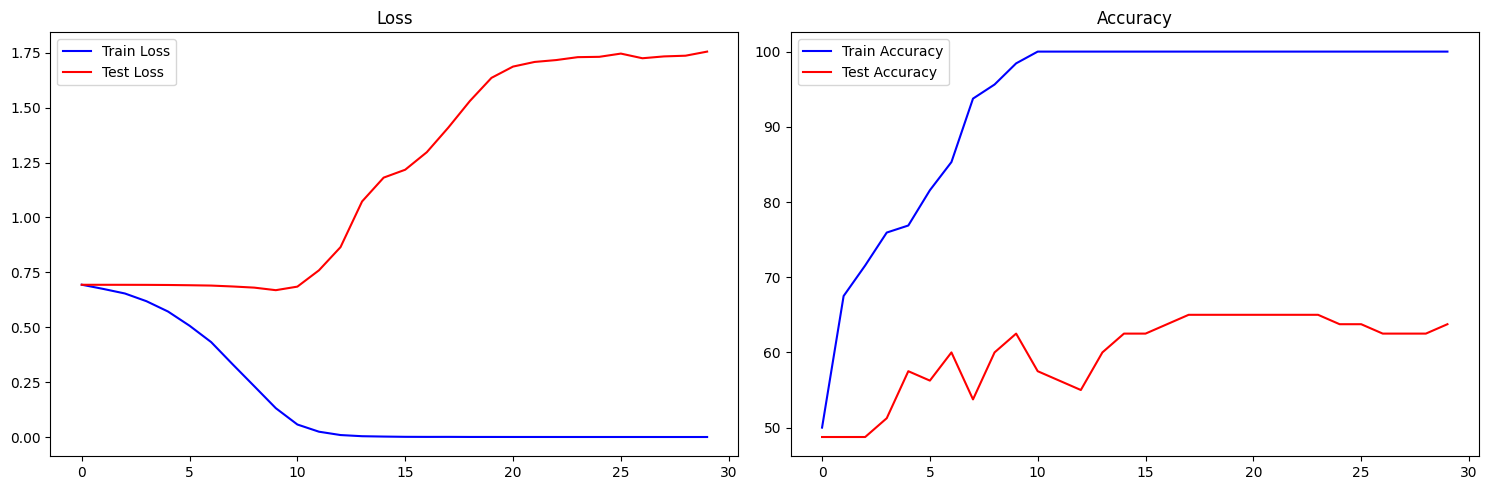

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_loss, label='Train Loss', color='blue')
ax[0].plot(test_loss, label='Test Loss', color='red')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(train_acc, label='Train Accuracy', color='blue')
ax[1].plot(test_acc, label='Test Accuracy', color='red')
ax[1].legend()
ax[1].set_title('Accuracy')
plt.tight_layout()
plt.show()